# Comparison of one-canyon runs

* No repeats, these experiments were done 3 on the same day but they are not repeats of each other
* Parameters can be found on google drive sheet lab_speadsheets/exp_list

Using calibration from August 17th (closest calibration when all probes were connected).


In [42]:
import cmocean as cmo
import glob
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy.io as sio
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(15, color=col, linestyle=':')
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [5]:
# Information for all runs is stored in experiment_dictionaries.py
lib_path = os.path.abspath('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts') # Add absolute path to my python scripts
sys.path.append(lib_path)

import experiment_dictionaries as exdic

In [6]:
exp_dicts = [exdic.S01, exdic.S02, exdic.S03, exdic.S04, 
             exdic.S05, exdic.S06, exdic.S07, exdic.S08,
             exdic.S09, exdic.S10, exdic.S11, exdic.S12]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']

### READINGS

../experiments/exp_19aug19/04_experiment1.mat
../experiments/exp_19aug19/08_experiment2.mat
../experiments/exp_19aug19/11_experiment3.mat
../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat
../experiments/exp_21aug19/04_experiment1.mat
../experiments/exp_21aug19/07_experiment2.mat
../experiments/exp_21aug19/11_experiment3.mat
../experiments/exp_22aug19/04_experiment1.mat
../experiments/exp_22aug19/07_experiment2.mat
../experiments/exp_22aug19/11_experiment3.mat


Text(0.5,0,'time / s')

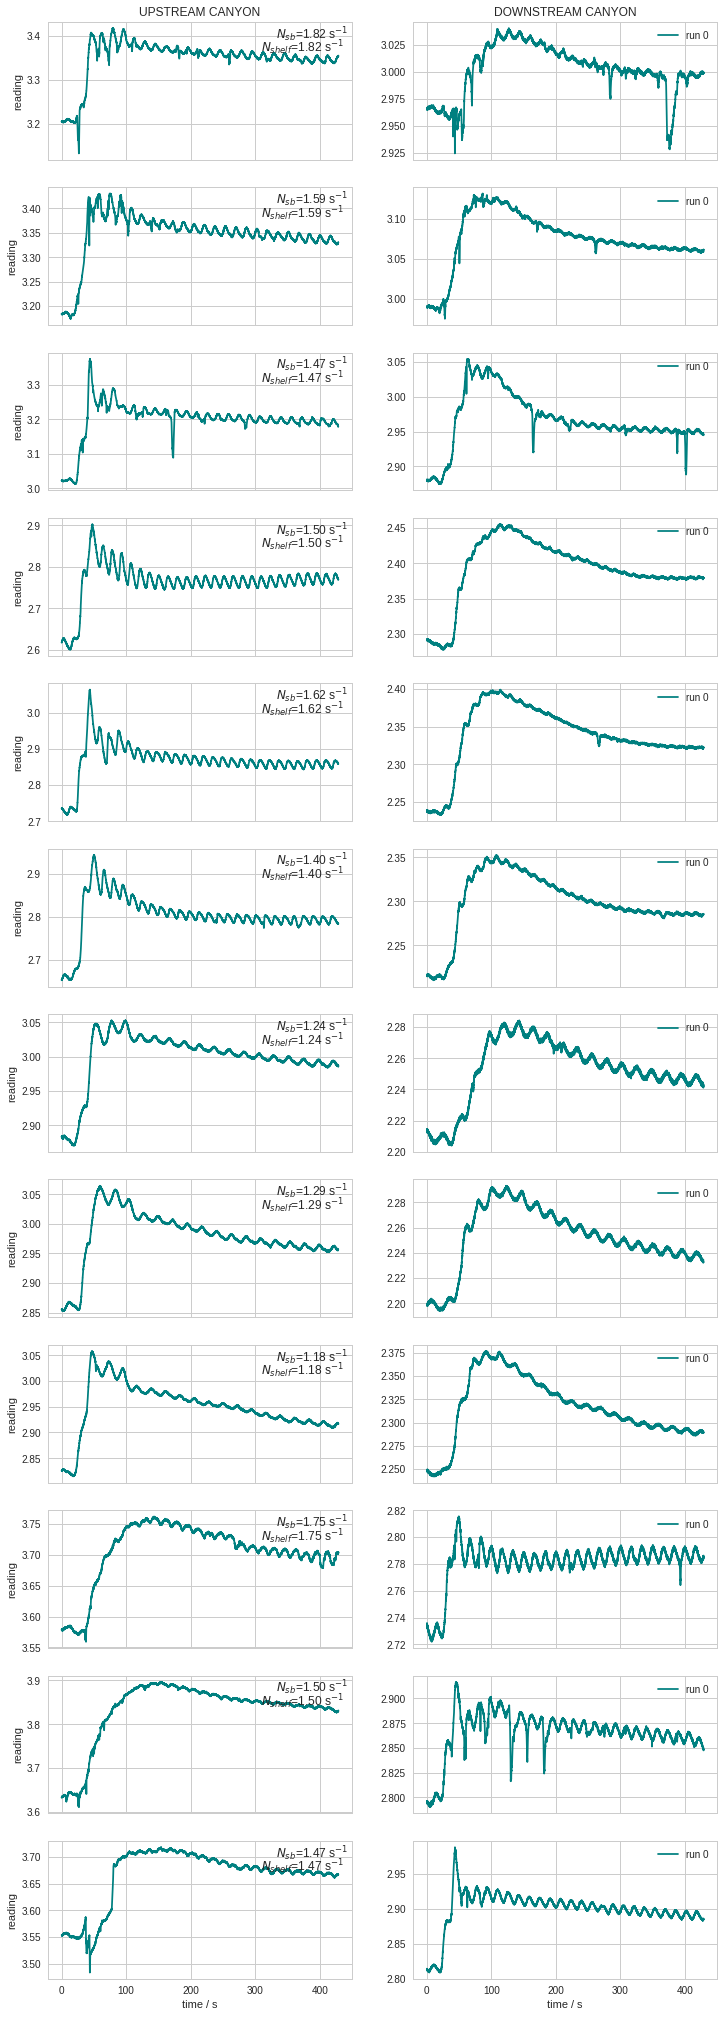

In [7]:
fig, ax = plt.subplots(exp_num, 2, figsize=(12,exp_num*3), sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')

for exp, kk in zip(exp_dicts, range(exp_num)):
    
    for ii, col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        print(filepath)
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        ax[kk,0].plot(time,P1,'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time,P2,'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.75,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.7,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
       
    ax[kk,0].set_ylabel('reading')
    ax[kk,1].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')


### Density change from initial value

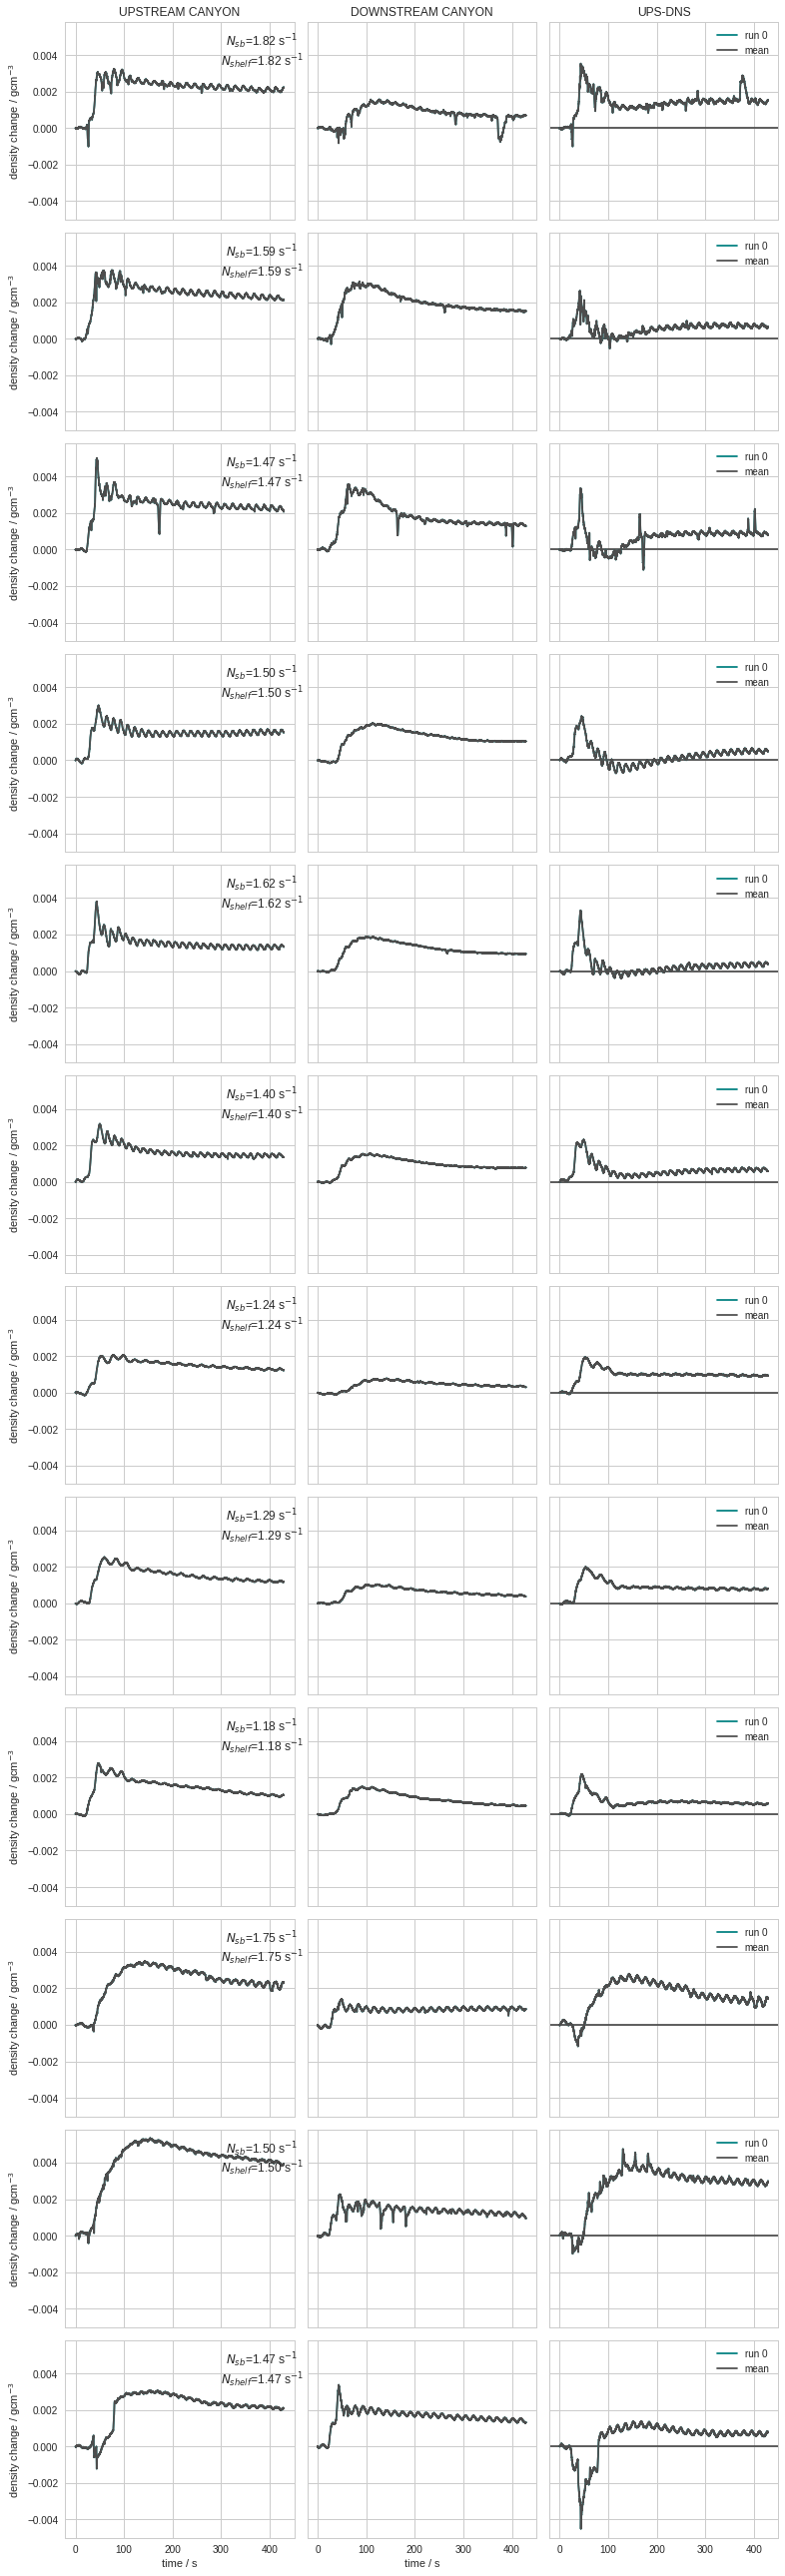

In [8]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

### Upstream vs downstream all runs

8.975979010256552
8.975979010256552
8.975979010256552
7.853981633974483
7.853981633974483
7.853981633974483
12.566370614359172
12.566370614359172
12.566370614359172
8.975979010256552
8.975979010256552
8.975979010256552


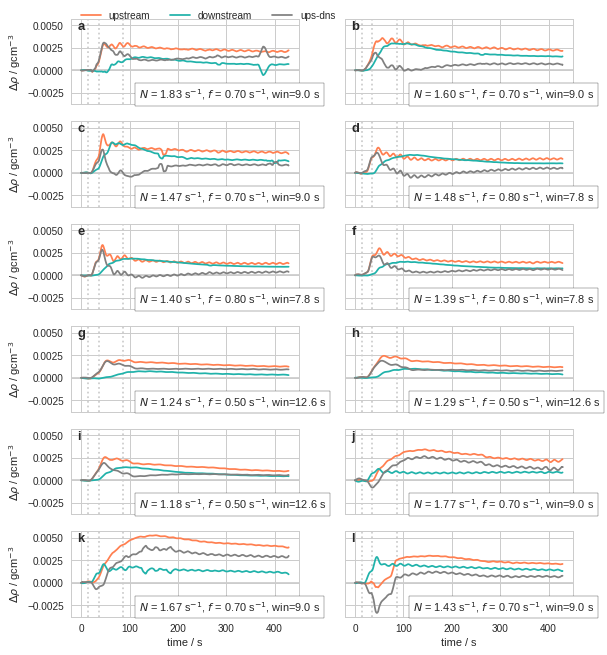

In [97]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(9,11), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81
for exp, kk, ax, pan_lab in zip(exp_dicts, range(exp_num), axs, panel_labels):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        print(inertial_period)
        ax.axhline(0, color='0.8')
        plot_uprofile(ax)
        ax.text(0.3,0.07,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, win=%1.1f s' \
                %(N,exp["fo"],win*dt), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
    
        ax.plot(time, ctools.filter_timeseries((dens1-dens1[0]),winlen=win),'-',
                color='coral', label='upstream')
        ax.plot(time, ctools.filter_timeseries((dens2-dens2[0]),winlen=win),'-',
                color='lightseagreen', label='downstream')
        ax.plot(time, ctools.filter_timeseries((dens1-dens1[0])-(dens2-dens2[0]),winlen=win),
                '-',color='0.5', label='ups-dns')    
        ax.text(0.03,0.88, pan_lab, fontweight='bold', fontsize=13, transform=ax.transAxes)

for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax10.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))
plt.savefig('figures/onecanyon_timeseries.eps', format='eps', transparent=False, bbox_inches='tight')

In [ ]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(9,11), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]

rho0=998.5
g = 9.81
for exp, kk, ax in zip(exp_dicts, range(exp_num), axs):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        print(inertial_period)
        ax.axhline(0, color='0.8')
        plot_uprofile(ax)
        ax.text(0.3,0.07,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, win=%1.1f s' \
                %(N,exp["fo"],win*dt), transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=1) )
    
        ax.plot(time, ctools.filter_timeseries((dens1-dens1[0]),winlen=win),'-',
                color='coral', label='upstream')
        ax.plot(time, ctools.filter_timeseries((dens2-dens2[0]),winlen=win),'-',
                color='lightseagreen', label='downstream')
        ax.plot(time, ctools.filter_timeseries((dens1-dens1[0])-(dens2-dens2[0]),winlen=win),
                '-',color='0.5', label='ups-dns')    
    

for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax10.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax1.legend(ncol=3,bbox_to_anchor=(-0.25,1.2))
plt.savefig('figures/onecanyon_timeseries_sel.eps', format='eps', transparent=False, bbox_inches='tight')

### Max depth of upwelling in upstream canyon

Text(0,0.5,'max $\\Delta \\rho$ canyon / g cm$^{-3}$')

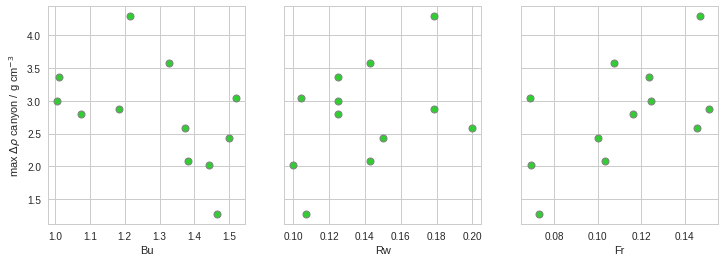

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        N =((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        Fr = exp["U"]/(N*exp["hsb"])

        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        sca = ax1.plot(Bu,np.max(delta_rho),
                       'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,np.max(delta_rho),
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca3 = ax3.plot(Fr,np.max(delta_rho),
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 

ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax3.set_xlabel('Fr')
ax1.set_ylabel(r'max $\Delta \rho$ canyon / g cm$^{-3}$')

Text(0,0.5,'Z / cm')

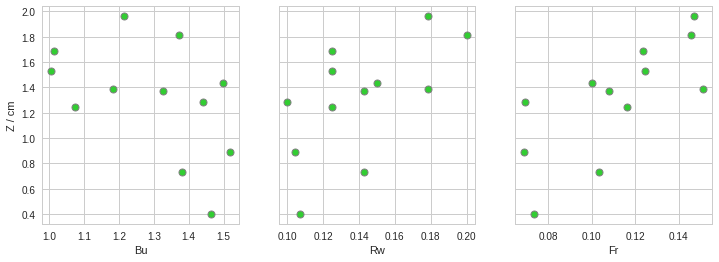

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        Fr = exp["U"]/(N*exp["hsb"])
  
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        Z = 100*(g/rho0)*(delta_rho/N**2) #cm
        sca = ax1.plot(Bu,Z,
                       'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,Z,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca3 = ax3.plot(Fr,Z,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 

ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax3.set_xlabel('Fr')
ax1.set_ylabel(r'Z / cm')

the mse is 0.072143


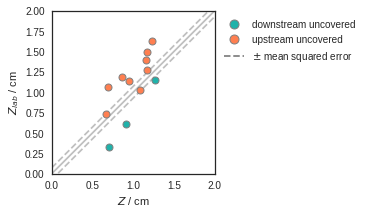

In [91]:
sns.set_context('notebook')
sns.set_style('white')
fig, ax1 = plt.subplots(1, 1, figsize=(2.5,2..5))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(Hs-0.005)))**0.5
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        inertial_period = 1/(f/(2*np.pi))
        win = int(inertial_period/dt)
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
            col = 'lightseagreen'
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
            col = 'coral'
        Z = (g/rho0)*(delta_rho/N**2) 
        
        sca = ax1.plot(Z_HA2013*100,Z*100,
                       'o',color=col, markeredgecolor='0.5', markeredgewidth=1,zorder=10) 
        Z_list.append(Z*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
ax1.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream uncovered',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream uncovered',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ mean squared error'),
                   ]

mse = mean_squared_error(Z_HA2013_list, Z_list)
print('the mse is %f' %mse)
ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1))
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+mse, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-mse, '--', color='0.5', alpha = 0.5,zorder=1)
plt.savefig('figures/Zlab_vs_Z_HA2013.eps', format='eps', transparent=False, bbox_inches='tight')

Comparison between measured depth of upwelling in one-canyon runs calculated as

$$\Delta Z = \frac{\Delta \rho}{N^2}\frac{g}{\rho_0}$$ 

and scaled depth of upwelling using estimate from Howatt and Allen 2013.
Blue points correspond to experiments with upstream canyon uncovered and orange points to experiments with downstream canyon uncovered. Relative to scaling, upstream canyon has lower Z and downstream canyon measures larger Z.

the mse is 0.072143


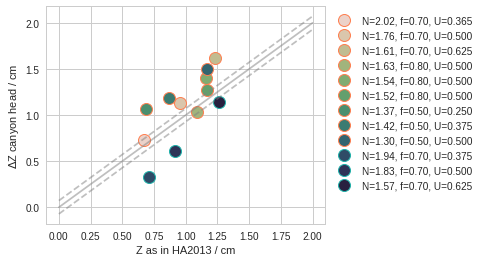

In [86]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,4), sharey=True)
sns.set_palette(sns.cubehelix_palette(12, start=.5, rot=-.95))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list = []
Z_HA2013_list = []
for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(Hs-0.005)))**0.5
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        inertial_period = 1/(f/(2*np.pi))
        win = int(inertial_period/dt)
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
            col = 'lightseagreen'
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
            col = 'coral'
        Z = (g/rho0)*(delta_rho/N**2) 
        
        sca = ax1.plot(Z_HA2013*100,Z*100,
                        'o',markersize=12,
                        markeredgecolor=col, markeredgewidth=1,
                        label='N=%1.2f, f=%1.2f, U=%1.3f' %(N,f,U*100)) 
        Z_list.append(Z*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
ax1.set_xlabel('Z as in HA2013 / cm')
ax1.set_ylabel(r'$\Delta$Z canyon head / cm')

mse = mean_squared_error(Z_HA2013_list, Z_list)
print('the mse is %f' %mse)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+mse, '--', color='0.5', alpha = 0.5)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-mse, '--', color='0.5', alpha = 0.5)
ax1.legend(bbox_to_anchor=(1,1))


0.8874579725918705
1.3699945122941186
1.9613206209984606
1.2482451135168873
1.6907965473539508
1.5318289294945304
1.2865440436883102
1.432432840271947
1.8105877182957175
0.40197445929931647
0.7352510192406172
1.3845809842794166


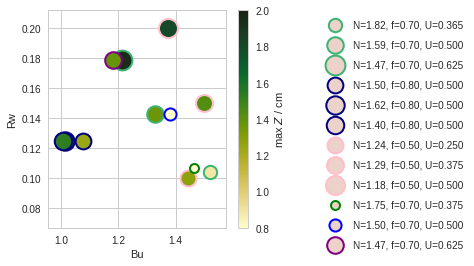

In [87]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        W = 5 # cm
        N =((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)

        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        Z = 100*(g/rho0)*(delta_rho/N**2) #cm
        print(Z)
        sca = ax1.scatter(Bu,Rw,
                          s=200*Z,
                          c=Z,
                          cmap=cmo.cm.speed,
                          vmax=2,
                          vmin=0.8,
                          marker='o',edgecolors=exp["color"],linewidth=2, 
                          label=('N=%1.2f, f=%1.2f, U=%1.3f' %(exp["Nshelf"],exp["fo"],exp["U"]))) 

cb = plt.colorbar(sca)
cb.set_label(r'max $Z$ / cm')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           

The plots above show that Z is porportional to Rw (and Fr) and inversely proportional to Bu, as expected :)

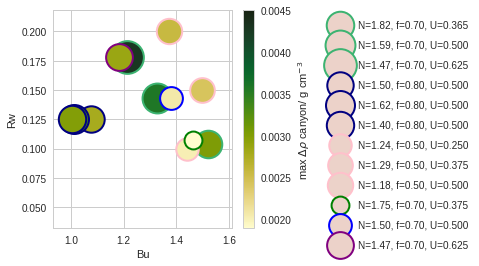

In [88]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        W = 5 # cm
        N =((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)

        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = (np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        else:
            delta_rho = (np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        sca = ax1.scatter(Bu,Rw,
                          s=250000*(np.max(delta_rho)),
                          c=np.max(delta_rho),
                          cmap=cmo.cm.speed,
                          vmax=0.0045,
                          vmin=0.0019,
                          marker='o',edgecolors=exp["color"],linewidth=2, 
                          label=('N=%1.2f, f=%1.2f, U=%1.3f' %(exp["Nshelf"],exp["fo"],exp["U"]))) 

cb = plt.colorbar(sca)
cb.set_label(r'max $\Delta \rho$ canyon/ g cm$^{-3}$')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           

Same but for the maximum density difference

### Depth of upwelling in anomaly (upstream-downstream)

Text(0,0.5,'Z / cm')

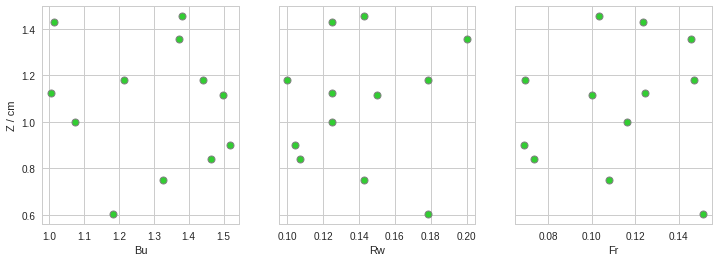

In [89]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        Fr = exp["U"]/(N*exp["hsb"])
  
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho = 1000*(np.max((ctools.filter_timeseries(dens1-dens1[0],winlen=win)-
                                  ctools.filter_timeseries(dens2-dens2[0],winlen=win)))) # kg/m^3
        Z = 100*(g/rho0)*(delta_rho/N**2) #cm
        sca = ax1.plot(Bu,Z,
                       'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,Z,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        sca3 = ax3.plot(Fr,Z,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 

ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax3.set_xlabel('Fr')
ax1.set_ylabel(r'Z / cm')

0.9007989626956988
0.7484479846350536
1.177955787884122
0.9975475471039834
1.4277744387294546
1.1224862449752666
1.1781022049351844
1.1146030983706097
1.3553072617895765
0.841937276334985
1.4539272133454701
0.604119050325391


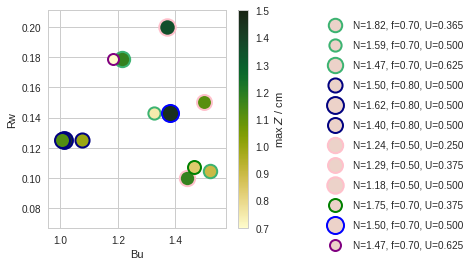

In [90]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        W = 5 # cm
        N =((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)

        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho = 1000*(np.max((ctools.filter_timeseries(dens1-dens1[0],winlen=win)-
                          ctools.filter_timeseries(dens2-dens2[0],winlen=win)))) # kg/m^3
        Z = 100*(g/rho0)*(delta_rho/N**2) #cm
        print(Z)
        sca = ax1.scatter(Bu,Rw,
                          s=200*Z,
                          c=Z,
                          cmap=cmo.cm.speed,
                          vmax=1.5,
                          vmin=0.7,
                          marker='o',edgecolors=exp["color"],linewidth=2, 
                          label=('N=%1.2f, f=%1.2f, U=%1.3f' %(exp["Nshelf"],exp["fo"],exp["U"]))) 

cb = plt.colorbar(sca)
cb.set_label(r'max $Z$ / cm')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           

Here it is not so clear. From the scatter plot above this one the dependence on Ro looks clear and for Bu there are 3 lines that decrease with increasing Bu but I don;t see that so clear in here.

In [91]:
s = (0.029-0.005)/(0.215)

In [92]:
s

0.11162790697674418

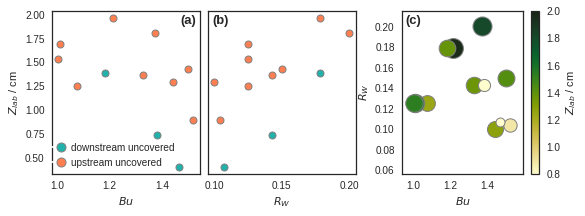

In [110]:
sns.set_style('white')
fig = plt.figure(figsize=(9,3))
gg = gspec.GridSpec(1, 2, wspace=0.2, width_ratios=[2,1])
gg1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gg[0], 
                                    wspace=0.05, width_ratios=[1,1])

ax1 = plt.subplot(gg1[0])
ax2 = plt.subplot(gg1[1])
ax2.set_yticks([], [])
ax3 = plt.subplot(gg[1])
rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
       
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        if exp['date']=='22Aug19':
            # Uncovered canyon
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
            col = 'lightseagreen'
        else:
            delta_rho = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
            col = 'coral'
        Z = 100*(g/rho0)*(delta_rho/N**2) #cm
        sca = ax1.plot(Bu,Z,
                       'o',color=col, markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,Z,
                        'o',color=col, markeredgecolor='0.5', markeredgewidth=1) 
        sca3 = ax3.scatter(Bu,Rw,
                          s=200*Z,
                          c=Z,
                          cmap=cmo.cm.speed,
                          vmax=2,
                          vmin=0.8,
                          marker='o',
                          edgecolors='0.5',#exp["color"],
                          linewidth=1, 
                          label=('N=%1.2fs$^{-1}$, f=%1.1frad/s, U=%1.2fcm/s' %(N,exp["fo"],exp["U"]))) 
cb = plt.colorbar(sca3)
cb.set_label(r'$Z_{lab}$ / cm')
ax1.set_xlabel('$Bu$')
ax2.set_xlabel('$R_W$')
ax3.set_ylabel('$R_W$')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax3.set_xlabel('$Bu$')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream uncovered',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream uncovered',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   ]

ax1.legend(handles=legend_elements,handletextpad=0, bbox_to_anchor=(0.89,0.25))
#ax3.legend(bbox_to_anchor=(1.5,1),labelspacing=1)       
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
plt.savefig('figures/Z_Ro_Rw.eps', format='eps', transparent=False, bbox_inches='tight')